In [14]:
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.chemistry.drivers import PySCFDriver, UnitsType, BasisType
from qiskit.chemistry.core import Hamiltonian, QubitMappingType
from qiskit.chemistry.transformations import FermionicTransformation
from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
import numpy as np
from math import pi
import matplotlib.pyplot as plt

In [20]:
# inter-atomic distance 
start = 0.5
step_size = 0.025
number_steps = 20
# Total distance increased = 0.5

# Number of distances thus created
distance = np.empty(number_steps + 1)    # 20 plus the start point 0.5
# np.empty(shape of array, data_type, ...)

distance[0] = start
for i in range(number_steps + 1):
    distance[i] = start + (i * step_size)
print(distance)

# or simply use this.
# distance = np.arange(0.5, 4.0, 0.1) 

[0.5   0.525 0.55  0.575 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775
 0.8   0.825 0.85  0.875 0.9   0.925 0.95  0.975 1.   ]


In [21]:
# Defining the molecule. 
# Each atom is seperated by semi colon (;) and, 
# Each atom is followed by a distance.
molecule = "H .0 .0 .0; H .0 .0 "
# molecule = "H .0 .0 -{0}; H .0 .0 {0}".format([d/2 for d in distance])

energy = []
hartree_fock_energy = []

for d in distance:
    driver = PySCFDriver(atom = molecule + str(d), unit = UnitsType.ANGSTROM, charge = 0, spin = 0, basis = 'sto3g')
    # Check what is basis type! 'sto3g' = BasisType.sto3g

    # qmolecule = driver.run()
    # print(qmolecule)

    operator = FermionicTransformation(qubit_mapping = QubitMappingType.PARITY)
    # or use Hamiltonian(qubit_mapping) but Hamiltonian is depriciated
    
    qubit_operator, auxiliary_operator = operator.transform(driver)
    # print(qubit_operator, auxiliary_operator)
    # SummedOp([-1.0692434904119303 * II, 0.26752864994208625 * IZ, 0.2675286499420862 * ZI, -0.00901493005816631 * ZZ, 0.19679058348547032 * XX])
    
    result = NumPyMinimumEigensolver(qubit_operator).run()
    # print(result)
    
    result = operator.interpret(result)
    # print(result)
    
    energy.append(float(result.total_energies))
    hartree_fock_energy.append(result.hartree_fock_energy)
    
print('energy: ', energy)
print('hf: ', hartree_fock_energy)

energy:  [-1.0551597944706248, -1.0759136551892523, -1.0926299067451022, -1.1059180532539932, -1.1162860068695386, -1.1241609196298883, -1.1299047843229129, -1.1338262151438596, -1.1361894540659208, -1.1372213770723023, -1.137117067345728, -1.1360443632279136, -1.1341476666770938, -1.1315512059072743, -1.1283618784581089, -1.1246717535661337, -1.120560281299988, -1.1160962367918728, -1.1113394177361497, -1.1063421092874426, -1.1011503302326173]
hf:  [-1.042996274540095, -1.0630621429206066, -1.0790507361774568, -1.0915704967771855, -1.101128242267701, -1.1081499901921303, -1.1129965456691684, -1.1159752638253104, -1.117349034990279, -1.1173432691225826, -1.1161514489386013, -1.113939661743049, -1.1108503974765953, -1.1070058079154392, -1.1025105539245943, -1.0974543197010043, -1.0919140410200565, -1.0859558749675393, -1.0796369282103728, -1.0730067566863368, -1.0661086493179366]


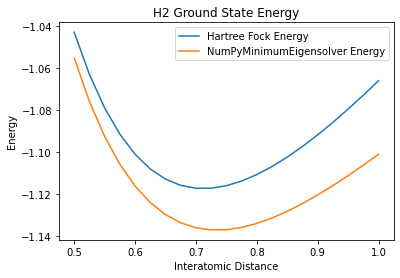

In [22]:
x_axis = distance
y_axis = hartree_fock_energy
y_axis_2 = energy

plt.plot(x_axis, y_axis, label = 'Hartree Fock Energy')
plt.plot(x_axis, y_axis_2, label = 'NumPyMinimumEigensolver Energy')
plt.xlabel('Interatomic Distance')
plt.ylabel('Energy')
plt.title('H2 Ground State Energy')
plt.legend(loc = 'upper right')

VQE

In [23]:
molecule = "H .0 .0 .0; H .0 .0 "

energy_VQE = []
hartree_fock_energy_VQE = []

aqua_globals.random_seed = 50

for d in distance:
    driver = PySCFDriver(atom = molecule + str(d), unit = UnitsType.ANGSTROM, charge = 0, spin = 0, basis = 'sto3g')
    
    # qmolecule = driver.run()
    # print(qmolecule)

    operator = FermionicTransformation(qubit_mapping = QubitMappingType.PARITY)
    
    qubit_operator, auxiliary_operator = operator.transform(driver)
    # print(qubit_operator, auxiliary_operator)
    
    optimizer = COBYLA(maxiter = 10000)
    
    # The two-local circuit is a parameterized circuit consisting of alternating rotation layers and entanglement layers.
    ansatz = TwoLocal(qubit_operator.num_qubits, rotation_blocks = ['ry', 'rx'], entanglement_blocks = 'cz', entanglement = 'linear', reps = 5)
    # TwoLocal(number of qubits, rotation block, entanglement block, linear/full entanglement, repetitions)
    # print(ansatz)
    
    algorithm = VQE(qubit_operator, ansatz, optimizer)
    result = algorithm.run(QuantumInstance(BasicAer.get_backend('statevector_simulator'), seed_simulator = aqua_globals.random_seed, seed_transpiler = aqua_globals.random_seed))
    # print(result)
    
    result = operator.interpret(result)
    # print(result)
    
    energy_VQE.append(float(result.total_energies))
    hartree_fock_energy_VQE.append(result.hartree_fock_energy)
    
print(ansatz)
print('energy: ', energy_VQE)
print('hf: ', hartree_fock_energy_VQE)

     ┌──────────┐┌──────────┐   ┌──────────┐┌──────────┐   ┌──────────┐»
q_0: ┤ RY(θ[0]) ├┤ RX(θ[2]) ├─■─┤ RY(θ[4]) ├┤ RX(θ[6]) ├─■─┤ RY(θ[8]) ├»
     ├──────────┤├──────────┤ │ ├──────────┤├──────────┤ │ ├──────────┤»
q_1: ┤ RY(θ[1]) ├┤ RX(θ[3]) ├─■─┤ RY(θ[5]) ├┤ RX(θ[7]) ├─■─┤ RY(θ[9]) ├»
     └──────────┘└──────────┘   └──────────┘└──────────┘   └──────────┘»
«     ┌───────────┐   ┌───────────┐┌───────────┐   ┌───────────┐┌───────────┐»
«q_0: ┤ RX(θ[10]) ├─■─┤ RY(θ[12]) ├┤ RX(θ[14]) ├─■─┤ RY(θ[16]) ├┤ RX(θ[18]) ├»
«     ├───────────┤ │ ├───────────┤├───────────┤ │ ├───────────┤├───────────┤»
«q_1: ┤ RX(θ[11]) ├─■─┤ RY(θ[13]) ├┤ RX(θ[15]) ├─■─┤ RY(θ[17]) ├┤ RX(θ[19]) ├»
«     └───────────┘   └───────────┘└───────────┘   └───────────┘└───────────┘»
«        ┌───────────┐┌───────────┐
«q_0: ─■─┤ RY(θ[20]) ├┤ RX(θ[22]) ├
«      │ ├───────────┤├───────────┤
«q_1: ─■─┤ RY(θ[21]) ├┤ RX(θ[23]) ├
«        └───────────┘└───────────┘
energy:  [-1.0551597900742886, -1.0759136520597254, -1.09262

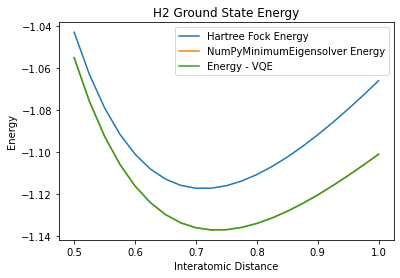

In [26]:
x_axis = distance
y_axis = hartree_fock_energy
y_axis_2 = energy
y_axis_3 = energy_VQE
# y_axis_4 = hartree_fock_energy_VQE

plt.plot(x_axis, y_axis, label = 'Hartree Fock Energy')
plt.plot(x_axis, y_axis_2, label = 'NumPyMinimumEigensolver Energy')
plt.plot(x_axis, y_axis_3, label = 'Energy - VQE')
# plt.plot(x_axis, y_axis_4, label = 'Hartree Fock Energy - VQE')
plt.xlabel('Interatomic Distance')
plt.ylabel('Energy')
plt.title('H2 Ground State Energy')
plt.legend(loc = 'upper right')

**Refer1:** https://qiskit.org/textbook/ch-applications/vqe-molecules.html#Structure-of-Common-Variational-Forms

**Refer2:** https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/chemistry/h2_vqe_initial_point.ipynb